# FINM 33165: HW3 Supporting Code

Vedant Pathak

## Imports

### IMPORTANT: Please set the ``PATH`` global in this cell to use the correct path to price data.

In [1]:
import numpy as np
import random
from collections import deque, namedtuple

import gymnasium as gym
from gymnasium import spaces

import pandas as pd

from statsmodels.tsa.stattools import coint

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "cm"

PATH = "../../data/price_data.pkl"

## ``gymnasium`` Environment Definition

In [2]:
class SpreadMomentumEnv(gym.Env):
    """
    Account-based spread trading environment with position size
    proportional to current equity (no transaction costs).

    - Uses dynamic hedge ratio beta_t from rolling OLS on log prices:
        log_a[t] = log(P^A_t)
        log_b[t] = log(P^B_t)
        beta_t ≈ Cov_w(log_a, log_b) / Var_w(log_b)

        spread[t] = log_a[t] - beta_t * log_b[t]

    - Actions (Discrete(4)):
        0 = Hold        (keep current position)
        1 = Long spread (size chosen ~ equity_t)
        2 = Short spread(size chosen ~ equity_t)
        3 = Liquidate   (flat: pos_a = pos_b = 0)

      For long / short spread:
        base_notional_t = P_A[t] + |beta_t| * P_B[t]
        k_t = leverage * equity_t / base_notional_t

        Long:  pos_a = +k_t, pos_b = -beta_t * k_t
        Short: pos_a = -k_t, pos_b = +beta_t * k_t

    - Each episode starts with:
        cash = initial_cash (default 1000.0)
        pos_a = 0
        pos_b = 0

    - Trades are self-financing:
        When we change positions, we buy/sell A & B at price_t and
        adjust cash by trade notional (no t-costs).

    - Reward at each step = change in equity from t to t+1:
        equity_t   = cash_t + pos_a * P_A[t] + pos_b * P_B[t]
        equity_t+1 = cash_{t+1} + pos_a * P_A[t+1] + pos_b * P_B[t+1]
        reward = equity_t+1 - equity_t

    - State:
        [spread, spread_diff, normalized_momentum, zscore,
         vol_spread_diff, spread_position (pos_a), equity_ratio]
    """

    metadata = {"render_modes": ["human"]}

    def __init__(
        self,
        prices_a,
        prices_b,
        window=20,
        initial_cash=1000.0,
        leverage=0.5,          # how many notional dollars of spread per 1 dollar equity
    ):
        super().__init__()

        prices_a = np.asarray(prices_a, dtype=np.float32)
        prices_b = np.asarray(prices_b, dtype=np.float32)
        assert len(prices_a) == len(prices_b), "Price series must have same length."

        if np.any(prices_a <= 0) or np.any(prices_b <= 0):
            raise ValueError("All prices must be positive for log operations.")

        self.prices_a = prices_a
        self.prices_b = prices_b
        self.window = window
        self.initial_cash = float(initial_cash)
        self.leverage = float(leverage)

        # Features in log-spread space with dynamic beta
        self._build_features()

        # State: 5 features + 1 position (pos_a) + 1 equity_ratio
        self.state_dim = self.features.shape[1] + 2
        self.action_space = spaces.Discrete(4)  # hold, long, short, liquidate
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(self.state_dim,),
            dtype=np.float32,
        )

        # Internal state
        self.pos_a = 0.0
        self.pos_b = 0.0
        self.cash = self.initial_cash
        self.equity = self.initial_cash
        self.t = self.start_idx

        # Histories for analysis
        self.history_cash = []
        self.history_pos_a = []
        self.history_pos_b = []
        self.history_equity = []

    def _build_features(self):
        # ----- LOG-PRICE series -----
        log_a = np.log(self.prices_a)
        log_b = np.log(self.prices_b)

        w = self.window
        kernel = np.ones(w, dtype=np.float32) / w

        # Rolling means
        mean_a = np.convolve(log_a, kernel, mode="same")
        mean_b = np.convolve(log_b, kernel, mode="same")

        # Rolling second moments
        mean_a2 = np.convolve(log_a**2, kernel, mode="same")
        mean_b2 = np.convolve(log_b**2, kernel, mode="same")
        mean_ab = np.convolve(log_a * log_b, kernel, mode="same")

        # Rolling covariance and variance
        cov_ab = mean_ab - mean_a * mean_b
        var_b = mean_b2 - mean_b**2
        var_b[var_b <= 0] = 1e-6

        # Dynamic beta_t = Cov(log_a, log_b) / Var(log_b)
        beta_t = cov_ab / var_b
        self.beta_t = beta_t

        # spread[t] = log_a[t] - beta_t[t] * log_b[t]
        spread = log_a - beta_t * log_b

        # Change in spread (approx. hedged log-return)
        spread_diff = np.diff(spread, prepend=spread[0])

        # Rolling stats for spread
        roll_mean = np.convolve(spread, kernel, mode="same")
        roll_var = np.convolve((spread - roll_mean) ** 2, kernel, mode="same")
        roll_std = np.sqrt(roll_var)
        roll_std[roll_std == 0] = 1e-6

        # z-score of spread
        zscore = (spread - roll_mean) / roll_std

        # normalized momentum
        mom_norm = spread_diff / (roll_std + 1e-6)

        # rolling volatility of spread differences
        mean_diff = np.convolve(spread_diff, kernel, mode="same")
        roll_var_diff = np.convolve(
            (spread_diff - mean_diff) ** 2, kernel, mode="same"
        )
        roll_std_diff = np.sqrt(roll_var_diff)
        roll_std_diff[roll_std_diff == 0] = 1e-6

        # Optional clipping
        spread_clipped = np.clip(spread, -10.0, 10.0)
        zscore_clipped = np.clip(zscore, -5.0, 5.0)
        mom_norm_clipped = np.clip(mom_norm, -5.0, 5.0)

        self.features = np.stack(
            [
                spread_clipped,      # 0: log spread (dynamic beta)
                spread_diff,         # 1: change in log spread
                mom_norm_clipped,    # 2: normalized momentum
                zscore_clipped,      # 3: z-score of log spread
                roll_std_diff,       # 4: volatility of spread differences
            ],
            axis=1,
        )

        # Valid index range
        self.start_idx = self.window
        self.end_idx = len(self.prices_a) - 2  # we use t and t+1 for PnL

    def _get_obs(self):
        feat = self.features[self.t]
        spread_position = self.pos_a  # number of "spread units" in A leg
        equity_ratio = self.equity / self.initial_cash
        obs = np.concatenate(
            [
                feat,
                np.array([spread_position], dtype=np.float32),
                np.array([equity_ratio], dtype=np.float32),
            ],
            axis=0,
        )
        return obs.astype(np.float32)

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.t = self.start_idx
        self.pos_a = 0.0
        self.pos_b = 0.0
        self.cash = self.initial_cash
        self.equity = self.initial_cash

        # reset histories
        self.history_cash = [self.cash]
        self.history_pos_a = [self.pos_a]
        self.history_pos_b = [self.pos_b]
        self.history_equity = [self.equity]
        self.history_pos = [0]
        self.actions = [0]

        obs = self._get_obs()
        return obs, {}

    def step(self, action):
        assert self.action_space.contains(action), "Invalid action."

        self.actions.append(action)

        # Prices now and next step
        P_A_t = float(self.prices_a[self.t])
        P_B_t = float(self.prices_b[self.t])
        P_A_t1 = float(self.prices_a[self.t + 1])
        P_B_t1 = float(self.prices_b[self.t + 1])

        # Equity before anything (mark-to-market on current prices)
        equity_before = self.cash + self.pos_a * P_A_t + self.pos_b * P_B_t

        # Decide target positions (trades executed at P_t, size ~ equity)
        target_pos_a = self.pos_a
        target_pos_b = self.pos_b

        if action == 0:  # Hold
            self.history_pos.append(self.history_pos[-1])

        elif action == 1:    # Long spread: size based on equity
            beta = float(self.beta_t[self.t])
            base_notional = P_A_t + abs(beta) * P_B_t
            if base_notional <= 0 or self.equity <= 0:
                k = 0.0
            else:
                k = (self.leverage * self.equity) / base_notional
            target_pos_a = k
            target_pos_b = -beta * k
            self.history_pos.append(1)

        elif action == 2:    # Short spread: size based on equity
            beta = float(self.beta_t[self.t])
            base_notional = P_A_t + abs(beta) * P_B_t
            if base_notional <= 0 or self.equity <= 0:
                k = 0.0
            else:
                k = (self.leverage * self.equity) / base_notional
            target_pos_a = -k
            target_pos_b = beta * k
            self.history_pos.append(-1)

        elif action == 3:    # Liquidate
            target_pos_a = 0.0
            target_pos_b = 0.0
            self.history_pos.append(0)

        # Compute trade deltas
        delta_a = target_pos_a - self.pos_a
        delta_b = target_pos_b - self.pos_b

        # Self-financing trade at current prices (no t-costs)
        trade_notional = delta_a * P_A_t + delta_b * P_B_t
        trade_cash_change = -trade_notional

        # Update cash and positions
        self.cash += trade_cash_change
        self.pos_a = target_pos_a
        self.pos_b = target_pos_b

        # Equity after price move to t+1 (mark to P_{t+1})
        equity_after = self.cash + self.pos_a * P_A_t1 + self.pos_b * P_B_t1
        reward = equity_after - equity_before

        # Commit new equity and time step
        self.equity = equity_after
        self.t += 1
        terminated = self.t >= self.end_idx
        truncated = False

        # Log histories (at new time index)
        self.history_cash.append(self.cash)
        self.history_pos_a.append(self.pos_a)
        self.history_pos_b.append(self.pos_b)
        self.history_equity.append(self.equity)

        obs = self._get_obs()
        return obs, float(reward), terminated, truncated, {}

    def render(self):
        print(
            f"t={self.t}, "
            f"pos_a={self.pos_a:.3f}, pos_b={self.pos_b:.3f}, "
            f"cash={self.cash:.2f}, equity={self.equity:.2f}"
        )

    def close(self):
        pass

## DQN Definition

In [3]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
        )

    def forward(self, x):
        return self.net(x)

## Replay Buffer Definition

In [4]:
Transition = namedtuple("Transition", ("state", "action", "reward", "next_state", "done"))


class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        batch = Transition(*zip(*batch))

        states = torch.tensor(batch.state, dtype=torch.float32)
        actions = torch.tensor(batch.action, dtype=torch.int64).unsqueeze(1)
        rewards = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(batch.next_state, dtype=torch.float32)
        dones = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

## Agent Definition

In [5]:
class DDQNAgent:
    def __init__(
        self,
        state_dim,
        action_dim,
        hidden_dim=128,
        gamma=0.99,
        lr=1e-3,
        buffer_size=100_000,
        batch_size=64,
        tau=0.005,
        device=None,
        target_update_freq=None,  # if you want hard updates, else None for soft every step
    ):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.batch_size = batch_size
        self.tau = tau
        self.target_update_freq = target_update_freq
        self.learn_step_counter = 0

        self.online_net = DQN(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_net = DQN(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_net.load_state_dict(self.online_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.online_net.parameters(), lr=lr)
        self.replay_buffer = ReplayBuffer(buffer_size)

    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randrange(self.online_net.net[-1].out_features)
        state_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.online_net(state_t)
        return int(q_values.argmax(dim=1).item())

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return None, None

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(
            self.batch_size
        )
        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device)

        # Current Q-values
        q_values = self.online_net(states).gather(1, actions)

        # Double DQN target
        with torch.no_grad():
            next_q_online = self.online_net(next_states)
            next_actions = next_q_online.argmax(dim=1, keepdim=True)

            next_q_target = self.target_net(next_states)
            next_q = next_q_target.gather(1, next_actions)

            target_q = rewards + (1.0 - dones) * self.gamma * next_q

        loss = nn.MSELoss()(q_values, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.online_net.parameters(), max_norm=10.0)
        self.optimizer.step()

        self.learn_step_counter += 1

        # Target network update: soft every step OR hard periodic
        if self.target_update_freq is None:
            # soft update every step
            with torch.no_grad():
                for target_param, param in zip(
                    self.target_net.parameters(), self.online_net.parameters()
                ):
                    target_param.data.mul_(1.0 - self.tau)
                    target_param.data.add_(self.tau * param.data)
        else:
            # hard update every N steps
            if self.learn_step_counter % self.target_update_freq == 0:
                self.target_net.load_state_dict(self.online_net.state_dict())

        # Diagnostics: avg max Q
        with torch.no_grad():
            max_q_vals = self.online_net(states).max(dim=1)[0]
            avg_max_q = max_q_vals.mean().item()

        return float(loss.item()), float(avg_max_q)

## Training Loop

In [6]:
def train_ddqn(
    prices_a,
    prices_b,
    num_episodes=50,
    start_epsilon=1.0,
    end_epsilon=0.05,
    epsilon_decay_episodes=40,
):
    env = SpreadMomentumEnv(prices_a, prices_b)
    sample_obs, _ = env.reset()
    state_dim = sample_obs.shape[0]
    action_dim = env.action_space.n

    agent = DDQNAgent(
        state_dim=state_dim,
        action_dim=action_dim,
        hidden_dim=128,
        gamma=0.99,
        lr=1e-3,
        buffer_size=50_000,
        batch_size=64,
        tau=0.01,
        target_update_freq=None,  # or e.g. 100 for hard updates
    )

    epsilon = start_epsilon
    epsilon_decay = (start_epsilon - end_epsilon) / max(epsilon_decay_episodes, 1)

    rewards_per_episode = []
    avg_loss_per_episode = []
    avg_max_q_per_episode = []

    for ep in range(num_episodes):
        obs, _ = env.reset()
        done = False
        ep_reward = 0.0
        ep_losses = []
        ep_max_qs = []

        while not done:
            action = agent.select_action(obs, epsilon)
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.replay_buffer.push(
                obs, action, reward, next_obs, float(done)
            )
            loss, avg_max_q = agent.update()
            if loss is not None:
                ep_losses.append(loss)
            if avg_max_q is not None:
                ep_max_qs.append(avg_max_q)

            obs = next_obs
            ep_reward += reward

        rewards_per_episode.append(ep_reward)
        avg_loss_per_episode.append(
            np.mean(ep_losses) if len(ep_losses) > 0 else np.nan
        )
        avg_max_q_per_episode.append(
            np.mean(ep_max_qs) if len(ep_max_qs) > 0 else np.nan
        )

        # Epsilon decay
        if ep < epsilon_decay_episodes:
            epsilon = max(end_epsilon, epsilon - epsilon_decay)

        print(
            f"Episode {ep+1}/{num_episodes} - "
            f"Reward: {ep_reward:.4f} - "
            f"Avg Loss: {avg_loss_per_episode[-1]:.4f} - "
            f"Avg MaxQ: {avg_max_q_per_episode[-1]:.4f} - "
            f"Epsilon: {epsilon:.3f}"
        )

    env.close()

    # Plots
    episodes = np.arange(1, num_episodes + 1)

    history = {
        "episodes": episodes,
        "rewards": rewards_per_episode,
        "avg_loss": avg_loss_per_episode,
        "avg_max_q": avg_max_q_per_episode,
    }

    return agent, history

## Evaluation Code

In [7]:
def evaluate_ddqn(dates, agent, prices_a_eval, prices_b_eval):
    """
    Run the trained agent on a separate evaluation dataset.
    No learning, pure greedy policy (epsilon = 0).

    Returns:
        total_reward: cumulative equity change over the eval period
        history: dict with cash, pos_a, pos_b, equity time series
    """
    env = SpreadMomentumEnv(prices_a_eval, prices_b_eval)
    obs, _ = env.reset(options={"test": True})
    done = False
    total_reward = 0.0

    while not done:
        action = agent.select_action(obs, epsilon=0.0)  # greedy
        obs, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        done = terminated or truncated

    history = {
        "date": dates[21:],
        "cash": np.array(env.history_cash),
        "pos_a": np.array(env.history_pos_a),
        "pos_b": np.array(env.history_pos_b),
        "equity": np.array(env.history_equity),
        "pos": np.array(env.history_pos),
        "action": np.array(env.actions),
    }

    df = pd.DataFrame(history).set_index("date")

    env.close()

    return total_reward, df

## Code Used to Generate All Graphics

### Load Data and Determine Cointegrated Pair

In [8]:
prices = pd.read_pickle(PATH)
prices = prices.dropna()["Open"]

# Adapted from example in class notebook
def best_cointegrated_pair(prices: pd.DataFrame) -> list[tuple[str, str]]:
    log_prices = pd.DataFrame(index=prices.index, columns=prices.columns, data=np.log(prices.values))

    pairs = []

    for i in range(len(log_prices.columns)):
        for j in range(i + 1, len(log_prices.columns)):
            prices_i = log_prices.iloc[:, i]
            prices_j = log_prices.iloc[:, j]

            if np.corrcoef(prices_i, prices_j)[0, 1] > 0.9:
                if coint(prices_i, prices_j)[1] < 0.01:
                    pairs.append((log_prices.columns[i], log_prices.columns[j], coint(prices_i, prices_j)[1]))

    pairs = [(s1, s2) for s1, s2, _ in sorted(pairs, key=lambda x: x[-1])]

    return pairs[0]

a, b = best_cointegrated_pair(prices)
print(a, b)

HBAN SCHW


### Train Model, Show Training Performance

<>:16: SyntaxWarning: invalid escape sequence '\$'
<>:16: SyntaxWarning: invalid escape sequence '\$'
/var/folders/1k/02gbgjvd59z48knsb64tjd540000gn/T/ipykernel_47752/4013256097.py:16: SyntaxWarning: invalid escape sequence '\$'
  axes[0].set_ylabel("Reward (\$)")


Episode 1/100 - Reward: 49.5796 - Avg Loss: 20.4330 - Avg MaxQ: 10.5120 - Epsilon: 0.976
Episode 2/100 - Reward: -125.4570 - Avg Loss: 40.8847 - Avg MaxQ: 26.9742 - Epsilon: 0.952
Episode 3/100 - Reward: 45.0652 - Avg Loss: 84.9271 - Avg MaxQ: 48.5102 - Epsilon: 0.929
Episode 4/100 - Reward: 97.4130 - Avg Loss: 81.9666 - Avg MaxQ: 64.5152 - Epsilon: 0.905
Episode 5/100 - Reward: 32.6707 - Avg Loss: 70.9074 - Avg MaxQ: 75.2657 - Epsilon: 0.881
Episode 6/100 - Reward: -32.6423 - Avg Loss: 61.5374 - Avg MaxQ: 83.5221 - Epsilon: 0.857
Episode 7/100 - Reward: 90.2978 - Avg Loss: 52.6054 - Avg MaxQ: 89.7155 - Epsilon: 0.834
Episode 8/100 - Reward: 166.5935 - Avg Loss: 48.8561 - Avg MaxQ: 92.8818 - Epsilon: 0.810
Episode 9/100 - Reward: -23.1665 - Avg Loss: 47.9609 - Avg MaxQ: 93.8502 - Epsilon: 0.786
Episode 10/100 - Reward: 68.5807 - Avg Loss: 40.2553 - Avg MaxQ: 92.8769 - Epsilon: 0.762
Episode 11/100 - Reward: 486.1021 - Avg Loss: 36.2192 - Avg MaxQ: 90.4397 - Epsilon: 0.739
Episode 12/10

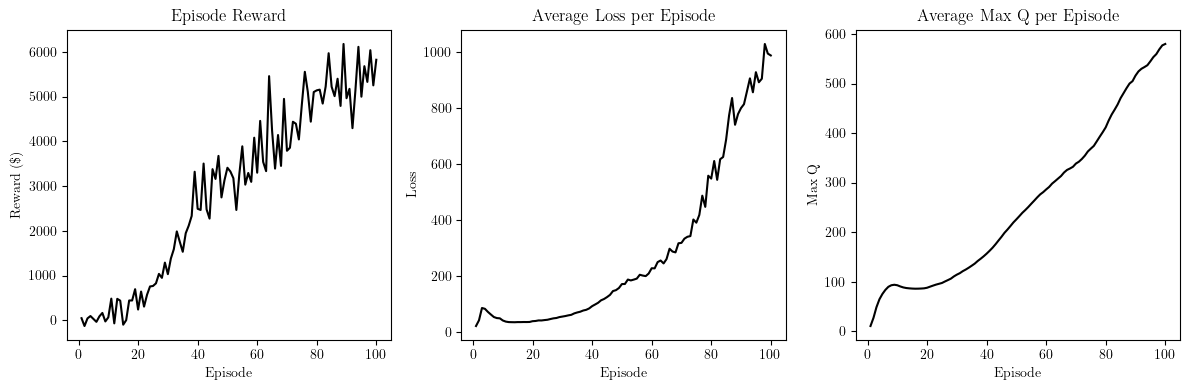

In [24]:
prices_train = prices[prices.index < pd.to_datetime("2017-01-01")]
prices_test = prices[prices.index >= pd.to_datetime("2017-01-01")]

pa_train = prices_train[a].values
pb_train = prices_train[b].values

pa_eval = prices_test[a].values
pb_eval = prices_test[b].values

agent, train_hist = train_ddqn(pa_train, pb_train, num_episodes=100)

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
axes[0].plot(train_hist["episodes"], train_hist["rewards"], c="black")
axes[0].set_title("Episode Reward")
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Reward (\$)")

axes[1].plot(train_hist["episodes"], train_hist["avg_loss"], c="black")
axes[1].set_title("Average Loss per Episode")
axes[1].set_xlabel("Episode")
axes[1].set_ylabel("Loss")

axes[2].plot(train_hist["episodes"], train_hist["avg_max_q"], c="black")
axes[2].set_title("Average Max Q per Episode")
axes[2].set_xlabel("Episode")
axes[2].set_ylabel("Max Q")

fig.tight_layout()
fig.savefig("ddqn_training.png", dpi=300)

### Run Model on Test Set, Show Test Performance

Eval total reward: -11.5674


<>:14: SyntaxWarning: invalid escape sequence '\$'
<>:16: SyntaxWarning: invalid escape sequence '\$'
<>:14: SyntaxWarning: invalid escape sequence '\$'
<>:16: SyntaxWarning: invalid escape sequence '\$'
/var/folders/1k/02gbgjvd59z48knsb64tjd540000gn/T/ipykernel_47752/2821318971.py:14: SyntaxWarning: invalid escape sequence '\$'
  perf_axes.set_title(f"Trade Performance (Max Drawdown: \${max_dd:.2f})")
/var/folders/1k/02gbgjvd59z48knsb64tjd540000gn/T/ipykernel_47752/2821318971.py:16: SyntaxWarning: invalid escape sequence '\$'
  perf_axes.set_ylabel("PnL (\$)")


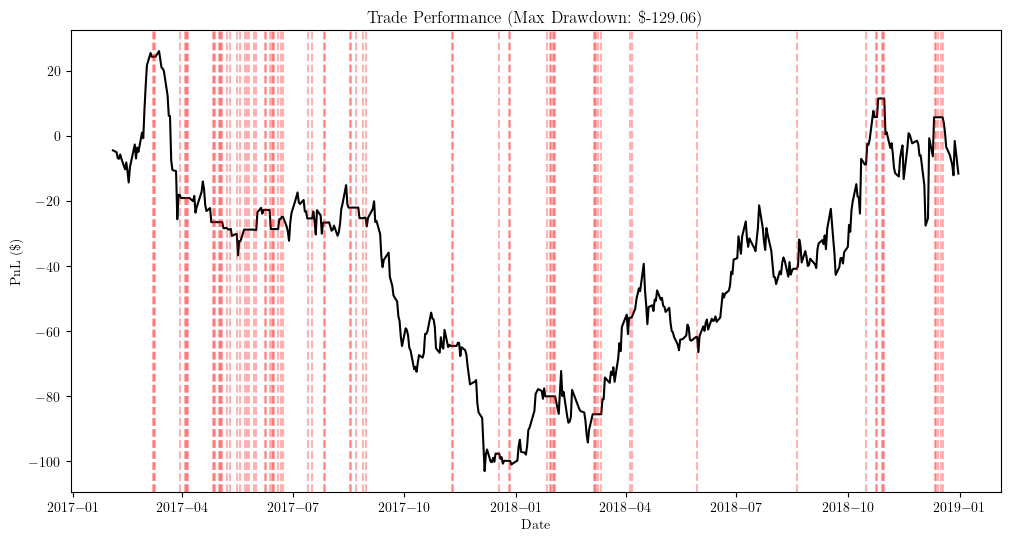

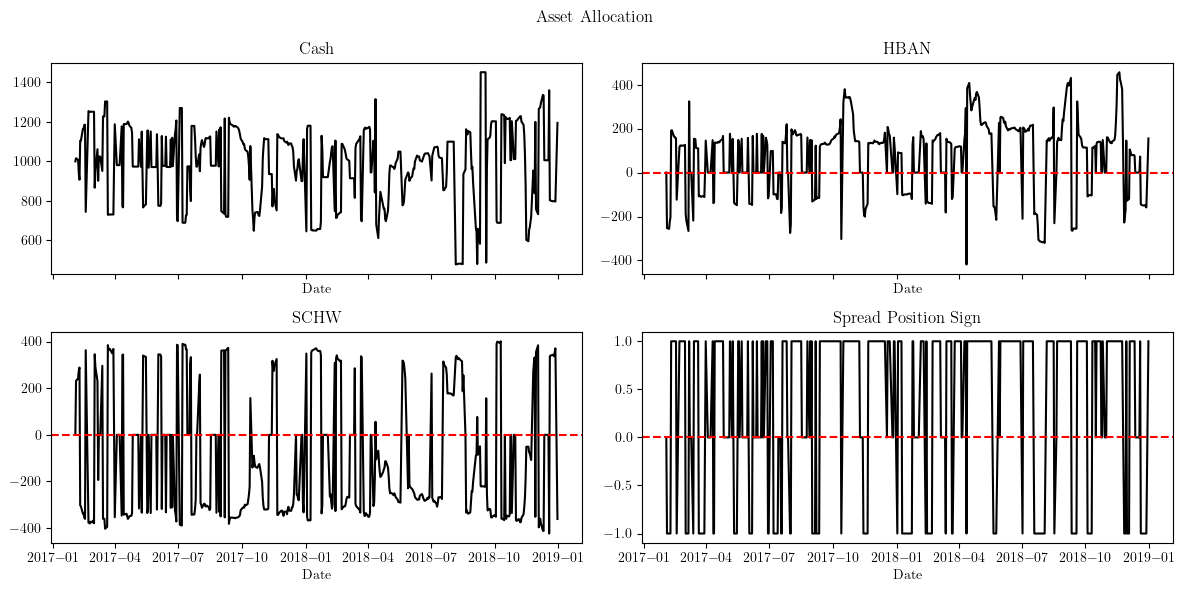

In [25]:
total_reward, eval_hist = evaluate_ddqn(prices_test.index, agent, pa_eval, pb_eval)
eval_hist = eval_hist.join(prices_test, how="left")
eval_hist["pos_a"] *= eval_hist[a]
eval_hist["pos_b"] *= eval_hist[b]

print(f"Eval total reward: {total_reward:.4f}")

eval_hist["pnl"] = eval_hist["equity"] - eval_hist["equity"].shift(1)

max_dd = (eval_hist["pnl"].cumsum() - eval_hist["pnl"].cumsum().cummax()).min()

perf_fig, perf_axes = plt.subplots(1, 1, figsize=(12, 6))
perf_axes.plot(eval_hist["pnl"].cumsum(), c="black")
perf_axes.set_title(f"Trade Performance (Max Drawdown: \${max_dd:.2f})")
perf_axes.set_xlabel("Date")
perf_axes.set_ylabel("PnL (\$)")

for ix, row in eval_hist.iterrows():
    if row["action"] == 3:
        perf_axes.axvline(x=ix, c="red", linestyle="--", alpha=0.3)

perf_fig.savefig("trade_performance.png", dpi=300)

fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
axes[0,0].plot(eval_hist["cash"], c="black")
axes[0,0].set_title("Cash")
axes[0,0].set_xlabel("Date")

axes[0,1].plot(eval_hist["pos_a"], c="black")
axes[0,1].set_title(a)
axes[0,1].set_xlabel("Date")
axes[0,1].axhline(y=0, c="red", linestyle="--")

axes[1,0].plot(eval_hist["pos_b"], c="black")
axes[1,0].set_title(b)
axes[1,0].set_xlabel("Date")
axes[1,0].axhline(y=0, c="red", linestyle="--")

axes[1,1].plot(eval_hist["pos"], c="black")
axes[1,1].set_title("Spread Position Sign")
axes[1,1].set_xlabel("Date")
axes[1,1].axhline(y=0, c="red", linestyle="--")

fig.suptitle("Asset Allocation")
fig.tight_layout()
fig.savefig("asset_allocation.png", dpi=300)

In [26]:
drawing_up = eval_hist["pnl"].cumsum() >= eval_hist["pnl"].cumsum().cummax()
drawing_down = eval_hist["pnl"].cumsum() <= eval_hist["pnl"].cumsum().cummin()
draws = pd.DataFrame({"drawup": drawing_up, "drawdown": drawing_down})

dup, ddown = False, False
dup_lengths = [0]
ddown_lengths = [0]

for ix, row in draws.iterrows():
    if row["drawup"] and dup:
        dup_lengths[-1] += 1
    elif row["drawup"] and not dup:
        dup = True
        dup_lengths.append(1)
    elif row["drawdown"] and ddown:
        ddown_lengths[-1] += 1
    elif row["drawdown"] and not ddown:
        ddown = True
        ddown_lengths.append(1)
    else:
        continue

np.mean(dup_lengths), np.mean(ddown_lengths)

(np.float64(4.0), np.float64(21.0))